### Config

In [4]:
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
from langchain_groq import ChatGroq
from langchain.schema import Document
from langchain_core.runnables import RunnableLambda
from langchain_community.tools.tavily_search import TavilySearchResults
from pprint import pprint
import os
import time
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.embeddings import HuggingFaceEmbeddings

### Embedding & call llm

In [5]:

# embed_model = FastEmbedEmbeddings(
#     model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
#     cache_dir="./embedding_cache" 
# )

In [6]:
from sentence_transformers import SentenceTransformer

# embed_model = HuggingFaceEmbeddings(model_name="hiieu/halong_embedding", cache_folder="./embedding_cache")
embed_model = HuggingFaceEmbeddings(model_name="truro7/vn-law-embedding", cache_folder="./embedding_cache")

/var/folders/cc/64gffy7j1_79tlsdxkhtcjg00000gp/T/ipykernel_3369/3618425365.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embed_model = HuggingFaceEmbeddings(model_name="truro7/vn-law-embedding", cache_folder="./embedding_cache")
Invalid model-index. Not loading eval results into CardData.
Invalid model-index. Not loading eval results into CardData.


In [7]:
import os
groq_api_key = os.environ['GROQ_API_KEY']
llm = ChatGroq(model_name='Llama3-8b-8192', api_key=groq_api_key)

###  Chunking text

In [8]:
import json
with open("data/source/vectorstore.json", "r", encoding="utf-8") as f:
    chunks_with_metadata = json.load(f)

doc_splits = [
    Document(
        page_content=chunk["text"],
        metadata={
            "chapter": chunk["metadata"]["chapter"],
            "title": chunk["metadata"]["title"],
            "date": chunk["metadata"]["date"]
        }
    ) for chunk in chunks_with_metadata
]

In [9]:
doc_count = len(doc_splits)
doc_count

2607

## RAG

### save vector db in persist files

In [10]:
# persist_directory = "./real_estate_db/vectorstore_halong"
# persist_directory = './real_estate_db/vectorstore'
persist_directory = './real_estate_db/vectorstore_vn-law'

### chromadb

In [11]:
# vectorstore_created = Chroma.from_documents(documents=doc_splits,
#                                     embedding=embed_model,
#                                     persist_directory=persist_directory,
#                                     collection_name="vectorstore_vn_law")
# vectorstore_created.persist()

In [12]:
# call from existed db
vectorstore = Chroma(persist_directory=persist_directory, embedding_function=embed_model, collection_name="vectorstore_vn_law")
# vectorstore.get()

/var/folders/cc/64gffy7j1_79tlsdxkhtcjg00000gp/T/ipykernel_3369/3807471848.py:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(persist_directory=persist_directory, embedding_function=embed_model, collection_name="vectorstore_vn_law")


In [13]:
print("Number of stored documents:", vectorstore._collection.count())
# print("First document:", doc_splits[-1].page_content if doc_splits else "No documents found!")
print("Files in persistence directory:", os.listdir(persist_directory))

Number of stored documents: 2607
Files in persistence directory: ['46314cca-631d-4b09-800b-b6b2dd74e7af', 'chroma.sqlite3']


In [14]:
from chromadb import PersistentClient
client = PersistentClient(path=persist_directory)
collections = client.list_collections()
print("Available collections:", collections)


Available collections: ['vectorstore_vn_law']


In [15]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
retriever_lambda = RunnableLambda(lambda x: retriever.get_relevant_documents(x["question"]))

In [16]:
# from langchain.schema import Document
# from langchain_core.runnables import RunnableLambda

# # convert chunks to document
# def format_text_chunks(text_chunks):
#     return [Document(page_content=chunk) for chunk in text_chunks]

# retriever_lambda = RunnableLambda(lambda x: format_text_chunks(retriever.get_relevant_documents(x["question"])))

## Component prompts

In [17]:
filter_prompt = PromptTemplate(
    template="""
    You are an AI-based information filter responsible for categorizing user input questions.
    Your mission is to return a binary choice "yes" or "no" indicating whether the question is related to sensitive topics.
    Sensitive topics include hate-speech, sexuality, politics, historical, violence, religion.
    
    **IMPORTANT**: Your response **MUST** be a valid JSON object with a single key "score" and a value of "yes" or "no". 
    **NOTE**: If topic is related to vietnamese laws, its not the sensitive topic even refer to senstive topics. 
    **NOTE**: Some hate-speech often wrote in short cut ("đcm", "mm", "vl") 
    **DO NOT** include any other text or explanation.
    
    For example: 
    Input: "ai là người lãnh đạo đảng?"
    Output: {{"score": "yes"}}

    Input: "việt tân là ai?"
    Output: {{"score": "yes"}}
    
    Input: "đcmm"
    Output: {{"score": "yes"}}
    
    Input: "luật việt nam là như nào?"
    Output: {{"score": "no"}}
    
    Input: "tội hiếp dâm và giết người bị phán bao nhiêu năm tù?"
    Output: {{"score": "no"}}
    
    Question need to filtered: {question}
    """,
    input_variables=["question"]
)
filter_chain = (filter_prompt | llm | JsonOutputParser())

# test
question = "“Người sử dụng đất” được hiểu như thế nào theo quy định của Luật Đất đai năm 2024?"
filter_result = filter_chain.invoke({"question": question})
print(filter_result)

{'score': 'no'}


### Router

In [47]:
router_prompt = PromptTemplate(
    template="""You are an expert at routing a user question to a vectorstore or web search. 
    Use the vectorstore for questions on real estate laws in Vietnam. You do not need to be stringent with the keywords 
    in the question related to these topics. Otherwise, use web-search. Give a binary choice `"web_search"` 
    or `"vectorstore"` based on the question. Return the a JSON with a single key `"datasource"` and 
    no premable or explaination. Question to route: {question}""",
    input_variables=["question"],
)
start = time.time()
question_router = router_prompt | llm | JsonOutputParser()

# test
print(question_router.invoke({"question": question}))
end = time.time()
print(f"The time required to generate response by Router Chain in seconds:{end - start}")

{'datasource': 'vectorstore'}
The time required to generate response by Router Chain in seconds:0.7371640205383301


### Generator

In [19]:
from langchain_core.runnables import RunnableLambda

qa_prompt = PromptTemplate(
    template="""You are professor in field of Vietnam Law, answer question using pieces of retrieved context from newest Legal Document. 
    Let's analyze and solving the question step by step. 
    If you don't know the answer, just refuse answer in polite and friendly. 
    Answer question in detailed, make sure references vietnamese's law that prove for your answer. 
    For example:
    Question: Phạm vi điều chỉnh và đối tượng áp dụng Luật Đất đai năm 2024 là gì?
    Answer: 
    Điều 1. Phạm vi điều chỉnh
    Luật này quy định về chế độ sở hữu đất đai, quyền hạn và trách nhiệm của Nhà nước đại diện chủ sở hữu toàn dân về đất đai và thống nhất quản lý về đất đai, chế độ quản lý và sử dụng đất đai, quyền và nghĩa vụ của công dân, người sử dụng đất đối với đất đai thuộc lãnh thổ của nước Cộng hòa xã hội chủ nghĩa Việt Nam.
    Điều 2. Đối tượng áp dụng
    1. Cơ quan nhà nước thực hiện quyền hạn và trách nhiệm đại diện chủ sở hữu toàn dân về đất đai, thực hiện nhiệm vụ thống nhất quản lý nhà nước về đất đai.
    2. Người sử dụng đất.
    3. Các đối tượng khác có liên quan đến việc quản lý, sử dụng đất đai.'
    
    **IMPORTANT**: Your response **MUST** be in Vietnamese, **DO NOT** use any other language; and it must be courteous and professional.
    **NOTE**: The most recent versions of the Vietnamese government's papers must be cited.
    Question: {question} 
    Context: {context} 
    Answer: professor""",
    input_variables=["question", "document"],
)

# Chain
start = time.time()
rag_chain = (
    {"question": lambda x: x["question"], "context": retriever_lambda}
    | qa_prompt
    | llm
    | StrOutputParser()
)

# test
# question = "luật nhà ở 2024"
response = rag_chain.invoke({"question": question})
print(response)

/var/folders/cc/64gffy7j1_79tlsdxkhtcjg00000gp/T/ipykernel_3369/1680405280.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retriever_lambda = RunnableLambda(lambda x: retriever.get_relevant_documents(x["question"]))


Cảm ơn đã gửi câu hỏi và tài liệu về Luật Đất đai năm 2024. Để trả lời câu hỏi "Người sử dụng đất" được hiểu như thế nào theo quy định của Luật Đất đai năm 2024, chúng ta sẽ phân tích các điều khoản trong Luật này.

Theo Điều 4 của Luật Đất đai năm 2024, "Người sử dụng đất" được định nghĩa là:

"Người sử dụng đất được Nhà nước giao đất, cho thuê đất, công nhận quyền sử dụng đất; đang sử dụng đất ổn định, đủ điều kiện cấp Giấy chứng nhận quyền sử dụng đất, quyền sở hữu tài sản gắn liền với đất mà chưa được Nhà nước cấp Giấy chứng nhận quyền sử dụng đất, Giấy chứng nhận quyền sở hữu nhà ở và quyền sử dụng đất ở, Giấy chứng nhận quyền sử dụng đất, quyền sở hữu nhà ở và tài sản khác gắn liền với đất, Giấy chứng nhận quyền sử dụng đất, quyền sở hữu tài sản gắn liền với đất; nhận quyền sử dụng đất; thuê lại đất theo quy định của Luật này, bao gồm: 1) chủ đầu tư dự án đầu tư có sử dụng đất; 2) người sử dụng đất khác."

Việc định nghĩa này cho thấy "Người sử dụng đất" bao gồm các đối tượng sau

### Retriever

In [20]:
retrieval_grader_prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question in Real Estate Law field. 
    If the document contains keywords related to the user question, grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Return a binary score, either `"yes"` or `"no"`, to indicate whether the document is relevant to the question.
    Provide the response strictly as a JSON object with a single key `"score"` and no preamble or explanation.
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    """,
    input_variables=["question", "document"],
)
start = time.time()
retrieval_grader = retrieval_grader_prompt | llm | JsonOutputParser()

# test
docs = retriever.invoke(question)
end = time.time()

for i, doc in enumerate(docs):
    doc_txt = doc.page_content
    print(f"doc {i + 1} content: {doc_txt}")
    doc_grader = retrieval_grader.invoke({"question": question, "document": doc_txt})
    print(f"retriever {i + 1} grade: {doc_grader}")


doc 1 content: Điều 25.
Nghĩa vụ của công dân đối với đất đai
1. Chấp hành đúng các quy định của
pháp luật về đất đai. 2. Giữ gìn, bảo vệ và phát triển
tài nguyên đất. 3. Tôn trọng quyền sử dụng đất của
người sử dụng đất khác. Chương III QUYỀN VÀ NGHĨA VỤ CỦA
NGƯỜI SỬ DỤNG ĐẤT Mục 1. QUY
ĐỊNH CHUNG
retriever 1 grade: {'score': 'yes'}
doc 2 content: Điều 4. Người
sử dụng đất
Người sử dụng đất được Nhà nước
giao đất, cho thuê đất, công nhận quyền sử dụng đất; đang sử dụng đất ổn định,
đủ điều kiện cấp Giấy chứng nhận quyền sử dụng đất, quyền sở hữu tài sản gắn liền
với đất mà chưa được Nhà nước cấp Giấy chứng nhận quyền sử dụng đất, Giấy chứng
nhận quyền sở hữu nhà ở và quyền sử dụng đất ở, Giấy chứng nhận quyền sử dụng đất,
quyền sở hữu nhà ở và tài sản khác gắn liền với đất, Giấy chứng nhận quyền sử dụng
đất, quyền sở hữu tài sản gắn liền với đất; nhận quyền sử dụng đất; thuê lại đất
theo quy định của Luật này, bao gồm: 1
retriever 2 grade: {'score': 'yes'}
doc 3 content: . 10. Chủ đầu

### Hallucination

In [21]:
docs = "luật nhà ở 2024 quy định tất cả các thành viên trong gia đình trên 18t đều có quyền thừa kế"
response = "luật nhà ở 2013 quy định tất cả các thành viên trong gia đình trên 18t đều có quyền thừa kế"

In [22]:
hallucination_grader_prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is **strictly grounded in and supported by** a set of referenced legal documents about **Vietnam Real Estate Law**. 
    If the answer accurately reflects information from the provided legal documents **without introducing unsupported details, fabricating legal articles, or misstating years**, grade it as `"yes"`. Otherwise, grade it as `"no"`.
    Provide the binary score as a JSON with a single key `"score"` and no preamble or explanation. 
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}""",
    input_variables=["generation", "documents"],
)
start = time.time()
hallucination_grader = hallucination_grader_prompt | llm | JsonOutputParser()

# test
hallucination_grader_response = hallucination_grader.invoke({"documents": docs, "generation": response})
end = time.time()
print(f"The time required to generate response by the generation chain in seconds:{end - start}")
print(hallucination_grader_response)

The time required to generate response by the generation chain in seconds:0.3133809566497803
{'score': 'no'}


### ANswer grader

In [23]:
answer_grader_prompt = PromptTemplate(
    template="""You are an expert lawyer specializing in Real Estate Law in Vietnam, acting as a grader to assess whether an answer is useful in resolving a given question.   
    If the answer provides relevant and helpful legal information to address the user's question, grade it as `"yes"`. Otherwise, grade it as `"no"`.   
    Return the result strictly as a JSON object with a single key `"score"`, without any preamble or explanation.
    Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question}""",
    input_variables=["generation", "question"],
)
start = time.time()
answer_grader = answer_grader_prompt | llm | JsonOutputParser()

# test
answer_grader_response = answer_grader.invoke({"question": question,"generation": response})
end = time.time()
print(f"The time required to generate response by the answer grader in seconds:{end - start}")
print(answer_grader_response)

The time required to generate response by the answer grader in seconds:0.2322859764099121
{'score': 'no'}


### Websearch tool

In [24]:
tavily_api_key = os.environ['TAVILY_API_KEY']
web_search_tool = TavilySearchResults(k=3)


Single test web_search_tool

In [25]:
import os
from langchain.tools import TavilySearchResults

def search_web(query: str, k: int = 3):
    """
    Searches the web using Tavily API for the given query.
    
    Parameters:
    - query (str): The search query.
    - k (int): Number of search results to return (default is 3).
    
    Returns:
    - list: A list of search result snippets.
    """
    tavily_api_key = os.environ['TAVILY_API_KEY']
    web_search_tool = TavilySearchResults(k=k)
    
    try:
        results = web_search_tool.run(query)
        return results
    except Exception as e:
        print(f"Error while searching: {e}")
        return []

query = "TÌnh hình bất đọngo sản 2024"
search_results = search_web(query)
print(search_results)


[{'title': 'TỔNG HỢP THỊ TRƯỜNG BẤT ĐỘNG SẢN 2024 - HƯỚNG TỚI 2025', 'url': 'https://www.youtube.com/watch?v=cavyT74iC6s', 'content': 'Bộ Xây dựng vừa công bố thông tin về nhà ở và thị trường bất động sản quý IV/2024 và cả năm 2024. Theo đó, thị trường bất động sản 2024 ghi nhận nhiều diễn biến khả quan khi nguồn cung tăng mạnh so với các năm trước, lượng giao dịch có phần được cải thiện và tồn kho bất động sản đang có xu hướng giảm dần. Ngoài ra, dư nợ tín dụng kinh doanh bất động sản đất nền cũng tăng mạnh so với cuối năm 2023. Vậy, hay cùng nhìn lại các số liệu của thị trường bất động sản 2024 và hướng tới năm 2025 cùng [...] chúng tôi ngay sau đây. [...] TỔNG HỢP THỊ TRƯỜNG BẤT ĐỘNG SẢN 2024 - HƯỚNG TỚI 2025 | #TCBDS \n Tài chính & Kinh doanh \n 641 likes \n 27283 views \n 13 Feb 2025', 'score': 0.7771143}, {'title': 'Thị trường bất động sản cuối năm 2024: Kỳ vọng bứt phá', 'url': 'https://consosukien.vn/thi-truong-bat-dong-san-cuoi-nam-2024-ky-vong-but-pha.htm', 'content': 'Cụ thể

## LangGraphh

In [26]:
from typing_extensions import TypedDict
from typing import List

### State

class GraphState(TypedDict):
    question : str
    generation : str
    web_search : str
    documents : List[str]
    iterations: int

### Nodes

In [27]:
def parse_question(state):
    question = state["question"]
    return {"question": question}

In [28]:
from langchain.schema import Document
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    try:
        documents = retriever.invoke(question)
    except Exception as e:
        print(f"Error in retrieval: {e}")
        documents = []
    return {"documents": documents, "question": question}
#
def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    iterations = state.get("iterations", 0) + 1
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation, "iterations": iterations}
#
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score['score']
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}
#
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])
    iterations = state.get("iterations", 0) + 1

    # Web search
    docs = web_search_tool.run({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question, "iterations": iterations}

### Condition edges

In [29]:
def filter_question(state):
    """
    Filter the question for sensitive topics
    
    Args:
        state (dict): The current graph state
    
    Returns:
        dict: Updated state with decision to end or continue
    """
    print("---FILTER QUESTION---")
    question = state["question"]
    filter_result = filter_chain.invoke({"question": question})
    if filter_result["score"] == "yes":
        print("---SENSITIVE TOPIC DETECTED---")
        return "yes"
    else:
        print("---QUESTION PASSED FILTER---")
        return "no"

In [30]:
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})  
    print(source)
    print(source['datasource'])
    if source['datasource'] == 'web_search':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source['datasource'] == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


In [31]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


In [32]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    iterations = state.get("iterations", 0)
    print(f"number of iteration at this hallucination term: {iterations}")
    
    if iterations >= 5:
        print("GETTING MAX ATTEMPTS")
        return "end"

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score['score']

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question,"generation": generation})
        grade = score['score']
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### Add node

In [40]:
from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("parse_question", parse_question)
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generatae

### Entry & End points

In [41]:
workflow.set_conditional_entry_point(
    filter_question,
    {
        "yes": END,
        "no": "parse_question"
    },
)

workflow.add_conditional_edges(
    "parse_question",
    route_question,     
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "end": END
    },
)

In [42]:
app = workflow.compile()

## Test

In [43]:
inputs = {"question": "Phạm vi điều chỉnh và đối tượng áp dụng Luật Đất đai năm 2024 là gì?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")

        if key == "filter_question" and value == "yes":
            pprint("xin loi toi khong the tra loi cau hoi nay")
            break

    if "generation" in value:
        pprint(value["generation"])

---FILTER QUESTION---
---QUESTION PASSED FILTER---
---ROUTE QUESTION---
Phạm vi điều chỉnh và đối tượng áp dụng Luật Đất đai năm 2024 là gì?
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
'Finished running: parse_question:'
---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
---WEB SEARCH---
'Finished running: websearch:'
---GENERATE---
---CHECK HALLUCINATIONS---
number of iteration at this hallucination term: 2
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('Cảm ơn về câu hỏi của bạn!\n'
 '\n'
 'Phạm 

### Deploy model to gradio

In [44]:
def answer(input):
    question  = {"question": input}
    for output in app.stream(question):
        for key, value in output.items():
            if key == "filter_question" and value == "yes":
                return "Xin lỗi, mình không thể trả lời câu hỏi này vì nó chứa nội dung liên quan đến chủ đề nhạy cảm."

        if "generation" in value:
            return value["generation"]
    return "Xin lỗi, mình không có câu trả lời cho câu hỏi của bạn"

In [45]:
input = "mẹ m"
print(answer(input))

---FILTER QUESTION---
---SENSITIVE TOPIC DETECTED---
Xin lỗi, mình không có câu trả lời cho câu hỏi của bạn


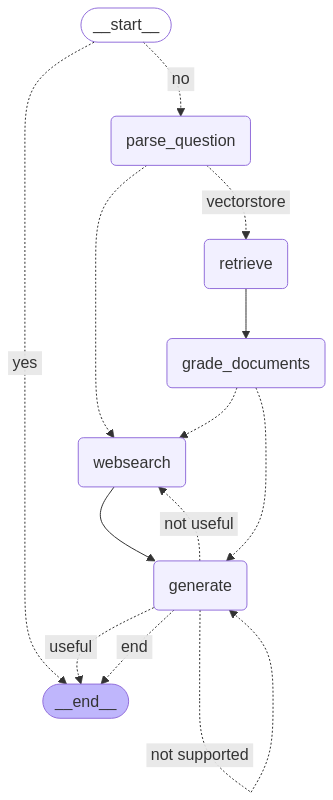

In [46]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)